# Voxelmorph pre-trained model exploration notebook

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

sys.path.insert(0, '../')

import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
from modules.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [3]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

warped_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

## SynthMorph

From their GitHub page:

> SynthMorph is a strategy for learning registration without acquired imaging data, producing powerful networks agnostic to contrast induced by MRI ([eprint arXiv:2004.10282](https://arxiv.org/abs/2004.10282)). For a video and a demo showcasing the steps of generating random label maps from noise distributions and using these to train a network, visit [synthmorph.voxelmorph.net](https://synthmorph.voxelmorph.net).
> 
> We provide model files for a ["shapes" variant](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5) of SynthMorph, that we train using images synthesized from random shapes only, and a ["brains" variant](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/brains-dice-vel-0.5-res-16-256f.h5), that we train using images synthesized from brain label maps. We train the brains variant by optimizing a loss term that measures volume overlap of a [selection of brain labels](https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/fs-labels.npy). For registration with either model, please use the `register.py` script with the respective model weights.

We will first download the model weights for the "shapes" variant:

In [13]:
!cd ../models && wget https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

--2021-11-03 11:21:07--  https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85150080 (81M)
Saving to: ‘shapes-dice-vel-3-res-8-16-32-256f.h5.1’

shapes-dice-vel-3-r 100%[===================>]  81.21M  7.64MB/s    in 15s     

2021-11-03 11:21:23 (5.30 MB/s) - ‘shapes-dice-vel-3-res-8-16-32-256f.h5.1’ saved [85150080/85150080]



In [19]:
path = '../data/ref.nii.gz'

# load reference image
ref = nib.load(path).get_fdata()

# min-max normalize
ref = (ref - ref.min()) / ref.max()

# save output
ref = nib.AnalyzeImage(ref, np.eye(4))
nib.save(ref, path)

In [11]:
ref = nib.load('../data/ref.nii.gz').get_fdata()
warped = nib.load('../data/warped.nii.gz').get_fdata()
flow = nib.load('../data/flow.nii.gz').get_fdata()

print(f'reference image shape: {ref.shape}')
print(f'warped image shape: {warped.shape}')
print(f'flow shape: {flow.shape}')

reference image shape: (160, 160, 192)
warped image shape: (160, 160, 192)
flow shape: (160, 160, 192, 3)


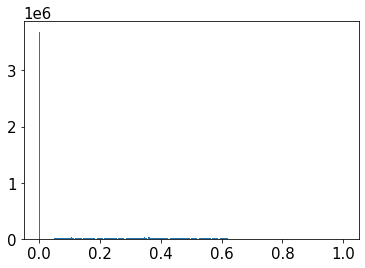

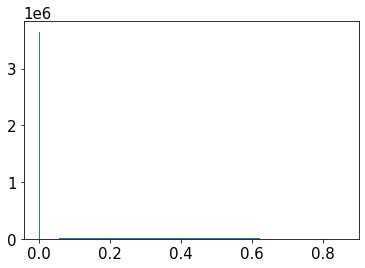

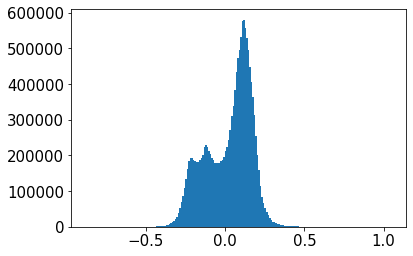

In [9]:
plt.hist(ref.ravel(), bins=200)
plt.show()
plt.hist(warped.ravel(), bins=200)
plt.show()
plt.hist(flow.ravel(), bins=200)
plt.show()

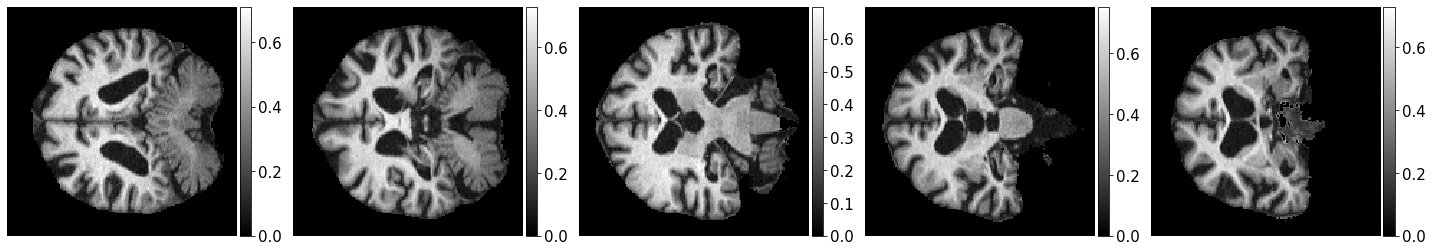

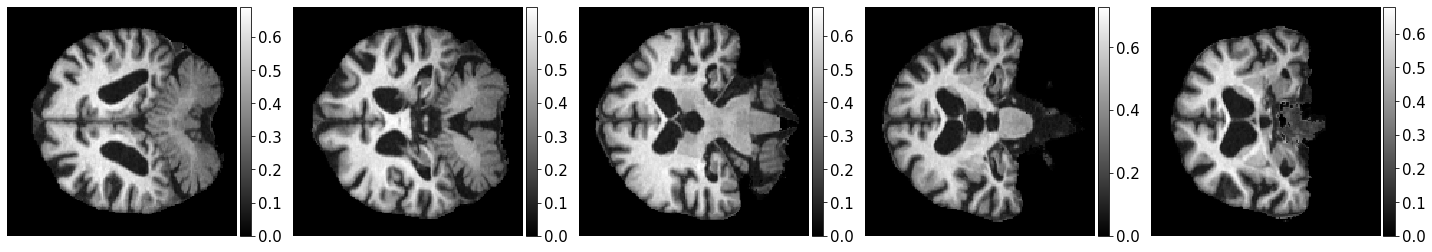

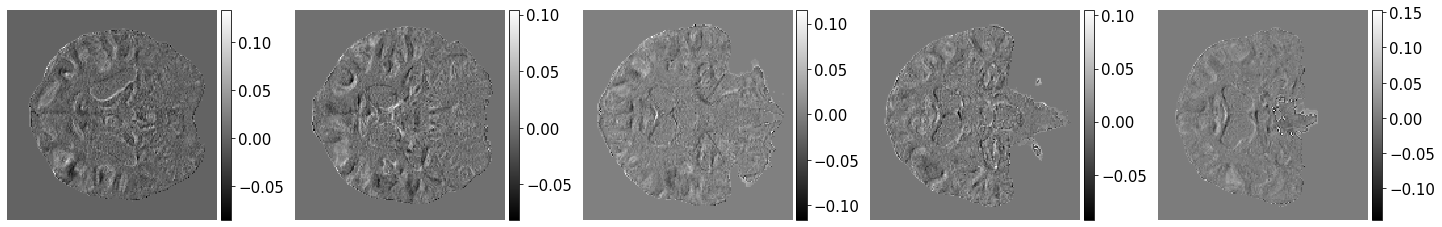

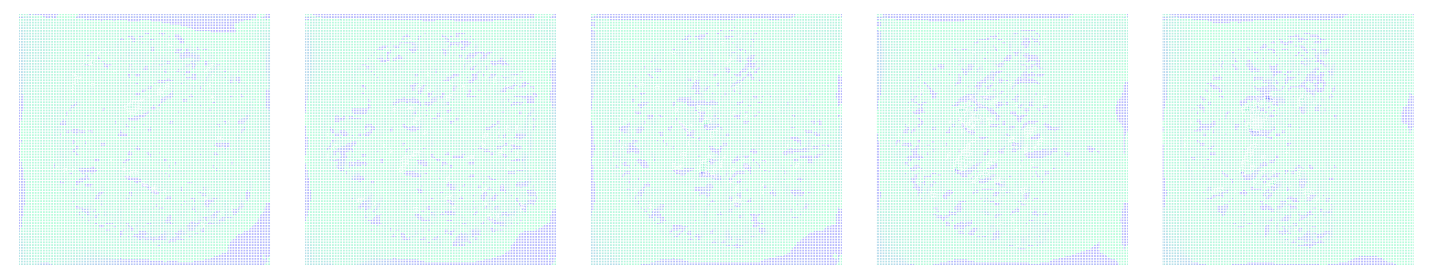

In [25]:
ran = range(60, 60 + 10*5, 10)
width = 20

# plots
imgs = [ref[..., i] for i in ran]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True, width=width)

imgs = [warped[..., i] for i in ran]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True, width=width);

imgs = [warped[..., i] - ref[..., i] for i in ran]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True, width=width);

imgs = [flow[..., i, :2] for i in ran]
# ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=False);
ne.plot.flow(imgs, width=width);

### Dataset to NiBabel format

We need our dataset to be in `.nii.gz` format so that we can input them to `register.py` and easily perform image registration:

In [91]:
try:
    del image
except Exception:
    pass

in_path = pystackreg_examples[1]
image = tiff.imread(in_path, key=range(10))
print(f'image shape: {image.shape}');

image shape: (10, 480, 736)


transform to `[0, 1]` range with min-max pixel values, as recomended in voxelmorph's github repo,

In [92]:
low, hig = image.min(), image.max()
normalized = (image - low) / (hig - low)

# voxelmorph saves data in x, y, z format. We will 
print(f'normalized shape: {normalized.shape}')

normalized shape: (10, 480, 736)


the model we will use expects 3d images with `shape=(None, 160, 160, 192, 1)`. We will simply tile each frame 196 times and downscale the frames to 160x160:

In [94]:
# downscale to 160 x 160. Default interpolation is bilinear
# resized = cv2.resize(normalized, (160, 160))
resized = np.stack([cv2.resize(frame, (160, 160)) for frame in normalized])

# add extra axis and tile
resized = np.tile(resized[..., np.newaxis], (1, 1, 192))
print(f'resized shape: {resized.shape}')

resized shape: (10, 160, 160, 192)


save in NiBabel's format

In [95]:
# save output
out_path = in_path.replace('.tif', '.nii.gz') 
nib.save(nib.AnalyzeImage(resized, np.eye(4)), out_path)

---

Now we make sure that the output was saved correctly.

We load the NiBabel image and visualize it,

image shape: (10, 160, 160, 192)


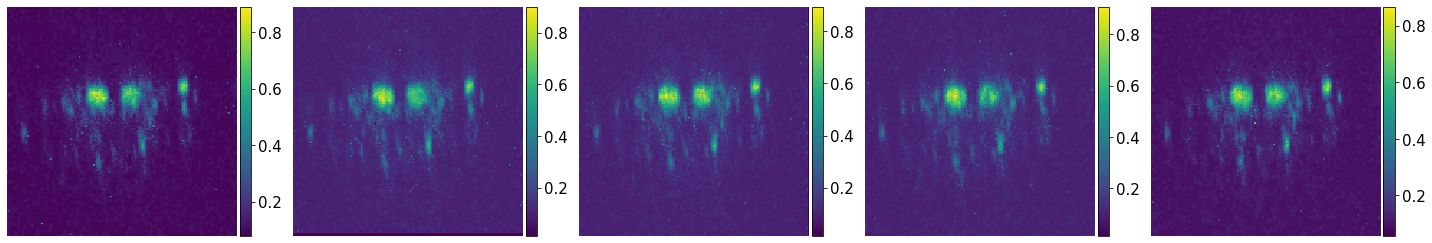

In [96]:
# load reference image
nib_image = nib.load(out_path).get_fdata()
print(f'image shape: {nib_image.shape}')

# plt.figure(figsize=(6, 6))
# ax = plt.subplot(111)
# ms = ax.matshow(nib_image[..., 0], cmap='viridis')
# plt.colorbar(ms);
imgs = [nib_image[i, ..., 0] for i in range(5)]
ne.plot.slices(imgs, cmaps=['viridis'], do_colorbars=True, width=20);

### Register 2-photon image

Here we will use `register.py` to stabilize the 2-photon image example from the previous section. We will use CPU since GPU ends with an OOM exception.

In [8]:
import os
in_path = pystackreg_examples[1]
out_path = in_path.replace('.tif', '.nii.gz')

model_path = os.path.abspath("../models/voxelmorph-brains-dice-vel-0.5-res-16-256f.h5")

taken from voxelmorph's `register.py` and [official tutorial](https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing) and adapted for multiple images,

In [22]:
!register-updated.py --batch --moving {out_path} --fixed {out_path} --moved warped.nii.gz --warp flow.nii.gz --model {model_path}

2021-11-05 10:29:09.183469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
moving.shape=(10, 160, 160, 192, 1)
fixed.shape=(10, 160, 160, 192, 1)
2021-11-05 10:29:14.233150: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-05 10:29:14.233685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-05 10:29:14.264325: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-05 10:29:14.264371: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: SV-87L-004
2021-11-05 10:29:14.264384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: SV-87L-004
2021-11-05 10:29:14.264497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] li

In [23]:
ref = nib.load(out_path).get_fdata()
warped = nib.load('warped.nii.gz').get_fdata()
flow = nib.load('flow.nii.gz').get_fdata()

print(f'reference image shape: {ref.shape}')
print(f'warped image shape: {warped.shape}')
print(f'flow shape: {flow.shape}')

reference image shape: (10, 160, 160, 192)
warped image shape: (10, 160, 160, 192)
flow shape: (10, 160, 160, 192, 3)


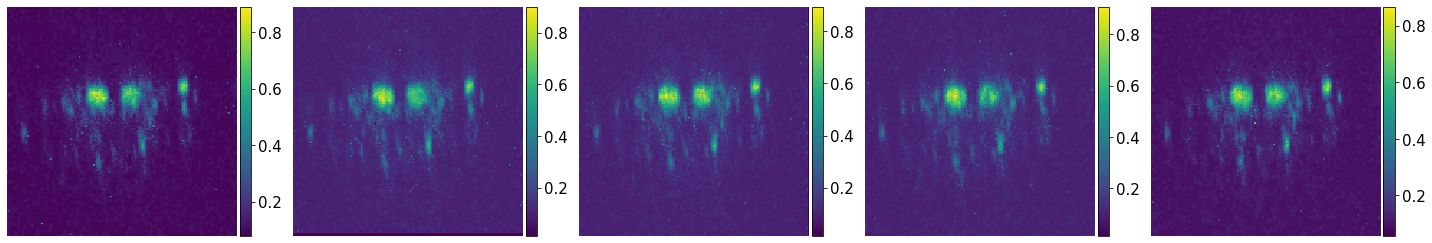

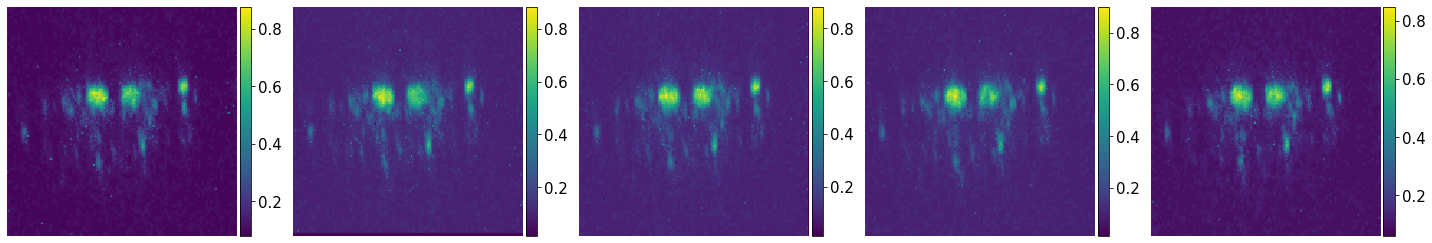

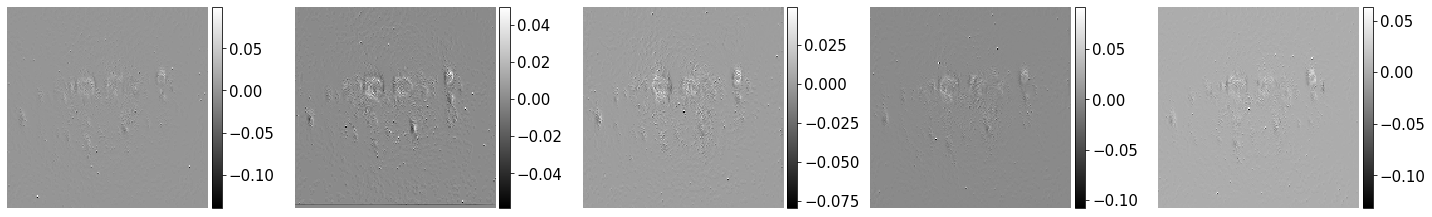

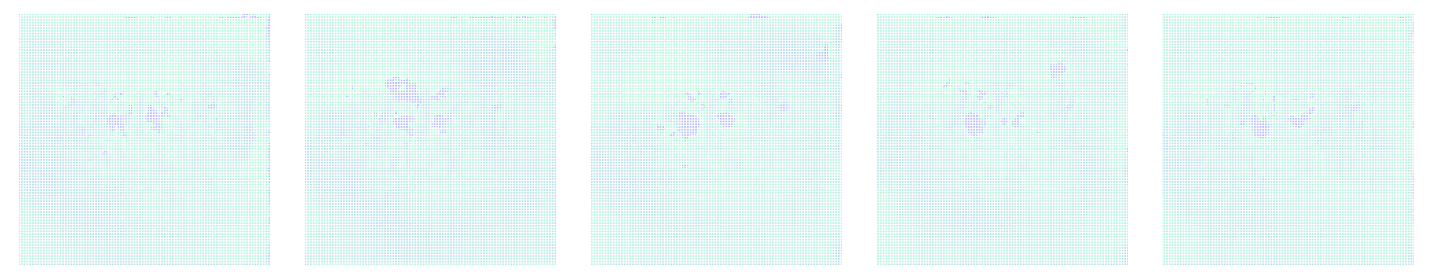

In [24]:
ran = range(5)
width = 20

# plots
imgs = [ref[i, ..., 0] for i in ran]
ne.plot.slices(imgs, cmaps=['viridis'], do_colorbars=True, width=width)

imgs = [warped[i, ..., 0] for i in ran]
ne.plot.slices(imgs, cmaps=['viridis'], do_colorbars=True, width=width);

imgs = [warped[i, ..., 0] - ref[i, ..., 0] for i in ran]
ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=True, width=width);

imgs = [flow[i, ..., 0, :2] for i in ran]
# ne.plot.slices(imgs, cmaps=['gray'], do_colorbars=False);
ne.plot.flow(imgs, width=width);

In [26]:
make_video('pysreg-example', frame_gen(ref[..., 0]), output_format='mp4')
Video('pysreg-example.mp4')

calculated std


10it [00:00, 1500.32it/s]

converting video..
Done (0.10s)


In [27]:
make_video('pysreg+vxm-example', frame_gen(warped[..., 0]), output_format='mp4')
Video('pysreg+vxm-example.mp4')

calculated std


10it [00:00, 1314.91it/s]

converting video..
Done (0.10s)


#### MSE score

In [28]:
from modules.metrics import MSE_score

MSE_score(ref[..., 0]), MSE_score(warped[..., 0])

(0.0008631766314535329, 0.0007353348655668414)

### Data generator

Now we will write our own code to load the model and, most importantly, generate the images we want to register automatically.

In [5]:
from modules.utils import vxm_register
import logging
logging.getLogger().setLevel(logging.INFO)

NUM_FRAMES = 50
print(f'{NUM_FRAMES=}')

in_path = orig_examples[1]
model_path = os.path.abspath("../models/voxelmorph-pretrained-vxm_dense_brain_T1_3D_mse.h5")
out_video, out_flow = vxm_register(in_path, model_path, strategy='GPU', key=range(NUM_FRAMES))
np.save('raw+vxm.npy', out_video)

INFO:root:Num Physical GPUs Available: 1


NUM_FRAMES=50


INFO:root:Num Logical  GPUs Available: 1
INFO:root:Num TPUs Available: 0
INFO:root:using GPU "MirroredStrategy" strategy.
/home/adrian/project/src/voxelmorph/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
/home/adrian/project/src/voxelmorph/voxelmorph/tf/networks.py:129: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

INFO:root:Loaded model in 0.96s
INFO:root:target_shape=(160, 192, 224, 1)
INFO:root:frame: 0


Model: "vxm_dense"
____________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                               Output Shape                            Param #              Connected to                                                
vxm_dense_source_input (InputLayer)                        [(None, 160, 192, 224, 1)]              0                                                                                
____________________________________________________________________________________________________________________________________________________________________________________
vxm_dense_target_input (InputLayer)                        [(None, 160, 192, 224, 1)]              0                                                                                
____________________________________________________________________________

INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:frame: 1
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:frame: 2
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:frame: 3
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:moved.shape=(5, 160, 192, 224, 1) | flow.shape=(5, 80, 96, 112, 3)
INFO:root:frame: 4


In [7]:
from modules.metrics import MSE_score
out_video = tiff.imread(in_path, key=range(NUM_FRAMES))
print(f'MSE score: {MSE_score(out_video) : ,.0f}')
make_video('raw', frame_gen(out_video))
Video('raw.mov')

MSE score:  3,971,823
calculated std


50it [00:00, 216.51it/s]


converting video..
Done (0.83s)


In [8]:
from modules.metrics import MSE_score
out_video = np.load('raw+vxm.npy')
print(f'MSE score: {MSE_score(out_video) : ,.0f}')
make_video('raw+vxm', frame_gen(out_video))
Video('raw+vxm.mov')

MSE score:  2,833,094
calculated std


50it [00:00, 228.04it/s]


converting video..
Done (0.66s)


RAW MSE SCORE:      3,971,823
RAW+VXM MSE SCORE:  2,833,094
RAW DICE SCORE:      0.70
RAW+VXM DICE SCORE:  0.71
raw.std()=3675.628671577966
raw_vxm.std()=3455.1416140308525


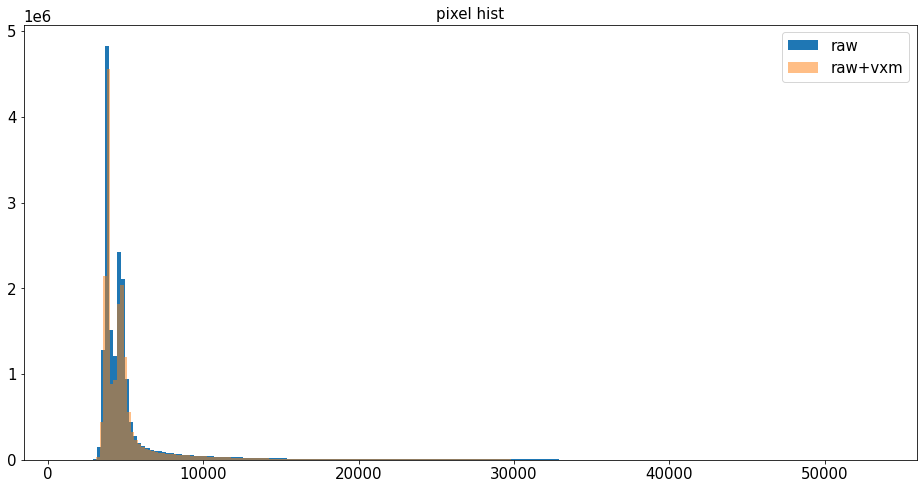

In [21]:
from modules.metrics import MSE_score, cont_dice_scores
from modules.utils import segment_video

raw = tiff.imread(in_path, key=range(NUM_FRAMES))
raw_vxm = np.load('raw+vxm.npy')

def DICE_SCORE(video):
    res = segment_video(video, sigma=1.0, num_reps=15, contrast=2.5)
    return cont_dice_scores(res).mean()

print(f'RAW MSE SCORE:     {MSE_score(raw) : ,.0f}')
print(f'RAW+VXM MSE SCORE: {MSE_score(raw_vxm) : ,.0f}')
print(f'RAW DICE SCORE:     {DICE_SCORE(raw) : .2f}')
print(f'RAW+VXM DICE SCORE: {DICE_SCORE(raw_vxm) : .2f}')

print(f'{raw.std()=}')
print(f'{raw_vxm.std()=}')

plt.figure(figsize=(16, 8))
plt.hist(raw.ravel(), bins=200, label=r'raw')
plt.hist(raw_vxm.ravel(), bins=200, alpha=.5, label=r'raw+vxm')
plt.legend()
plt.title('pixel hist')
plt.legend()
plt.show()

In [23]:
from modules.metrics import MSE_score
video = tiff.imread(in_path, key=range(51))
f'pysreg: {MSE_score(video):,.0f} | pysreg + vxm: {MSE_score(out_video):,.0f}'

'pysreg: 2,420,694 | pysreg + vxm: 1,703,186'

### Show difference between approaches

Video for empirical difference,

In [11]:
from modules.metrics import MSE_score


def four_frame_gen():
    key = range(50)
    raw = tiff.imread(orig_examples[1], key=key)
    pysreg = tiff.imread(pystackreg_examples[1], key=key)
    pysreg_vxm = np.load('pysreg+vxm.npy')
    ofco = tiff.imread(warped_examples[1], key=key)
    
    assert raw.shape[1] == pysreg.shape[1] == pysreg_vxm.shape[1] == ofco.shape[1]
    concat_video = np.c_[raw, pysreg, pysreg_vxm, ofco]
    print(f'{concat_video.shape=}')
    
    offy = 30
    
    raw_mse = MSE_score(raw)
    pysreg_mse = MSE_score(pysreg)
    pysreg_vxm_mse = MSE_score(pysreg_vxm)
    ofco_mse = MSE_score(ofco)
    
    C = raw.shape[2]
    for frame in frame_gen(concat_video):
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        frame[:, C::C] = 0
        frame = cv2.putText(frame, f'RAW | MSE={raw_mse:,.0f}',
                            (10, offy), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (255, 255, 255), 1, cv2.LINE_AA)
        frame = cv2.putText(frame, f'PYSREG | MSE={pysreg_mse:,.0f}',
                            (C+10, offy), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (255, 255, 255), 1, cv2.LINE_AA)
        frame = cv2.putText(frame, f'PYSREG+VXM | MSE={pysreg_vxm_mse:,.0f}',
                            (2*C+10, offy), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (255, 255, 255), 1, cv2.LINE_AA)
        frame = cv2.putText(frame, f'OFCO | MSE={ofco_mse:,.0f}',
                            (3*C+10, offy), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (255, 255, 255), 1, cv2.LINE_AA)
        yield frame.astype(np.uint8)


make_video('diffs', four_frame_gen(), output_format='mp4', cmap=None, output_shape=(480, 2944))
Video('diffs.mp4')

concat_video.shape=(50, 480, 2944)
calculated std


50it [00:00, 54.97it/s]


converting video..
Done (1.34s)


scores,

--------------------------------
raw
--------------------------------
calculated std


50it [00:00, 377.54it/s]

converting video..


Done (0.16s)
0


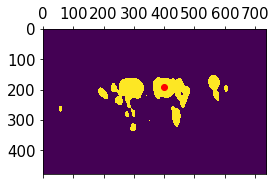

Computed score in 0.009s
dice scores: mean: 0.82 | std: 0.10 | min: 0.53 | max: 0.92


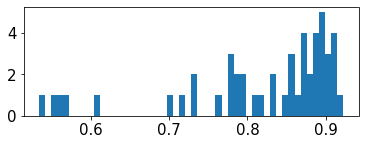

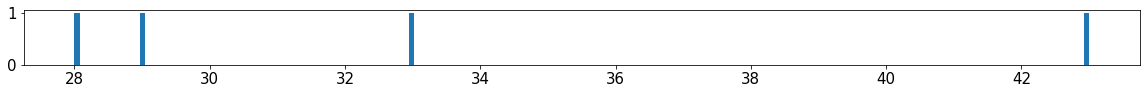

MEAN DISCRETE SCORE:  0.8179198364622736
MEAN CONT SCORE:      0.6964937090587245
Failure score:        0.0000%
--------------------------------
pysreg
--------------------------------
calculated std


50it [00:00, 374.71it/s]

converting video..


Done (0.15s)
0


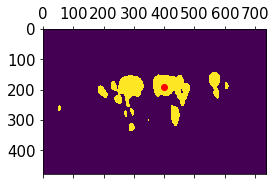

Computed score in 0.010s
dice scores: mean: 0.90 | std: 0.01 | min: 0.86 | max: 0.92


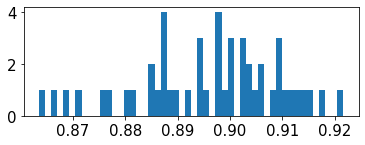

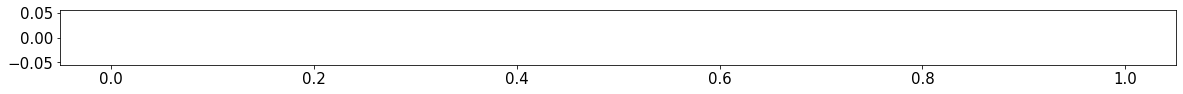

MEAN DISCRETE SCORE:  0.895948271403714
MEAN CONT SCORE:      0.7936935654786196
Failure score:        0.0000%
--------------------------------
pysreg_vxm
--------------------------------
calculated std


50it [00:00, 362.75it/s]

converting video..


Done (0.15s)
0


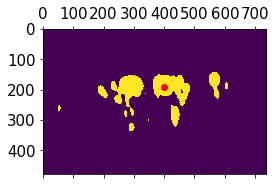

Computed score in 0.010s
dice scores: mean: 0.89 | std: 0.02 | min: 0.85 | max: 0.92


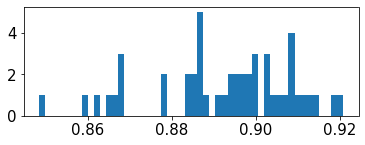

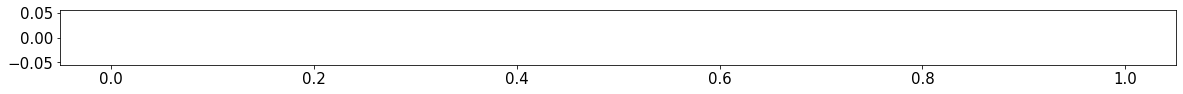

MEAN DISCRETE SCORE:  0.8924099371070289
MEAN CONT SCORE:      0.7610572310761665
Failure score:        0.0000%
--------------------------------
ofco
--------------------------------
calculated std


50it [00:00, 375.77it/s]

converting video..


Done (0.14s)
0


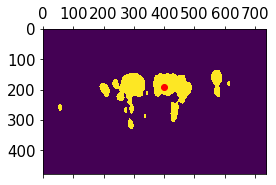

Computed score in 0.009s
dice scores: mean: 0.93 | std: 0.01 | min: 0.90 | max: 0.95


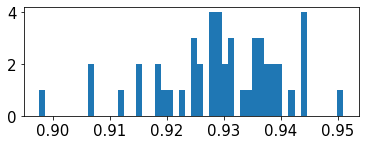

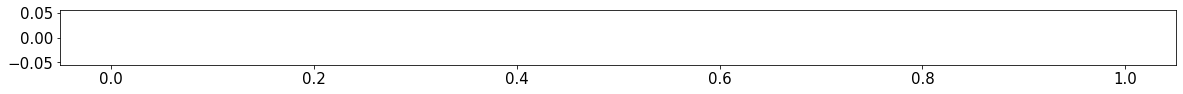

MEAN DISCRETE SCORE:  0.9295423448481106
MEAN CONT SCORE:      0.814856908887515
Failure score:        0.0000%


In [23]:
import time
from concurrent.futures.thread import ThreadPoolExecutor
from modules.metrics import cont_dice_scores, failure_score
from modules.utils import segment_video, blur_video


def dice_scores(video: np.ndarray) -> float:
    def loop(i):
        X_n_Y = np.sum(video[i] & video[i+1])
        X = np.sum(video[i])
        Y = np.sum(video[i+1])
        return 2 * X_n_Y / (X + Y)

    # use parallelism
    res = []
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(loop, i)
            for i in range(len(video)-1)
        ]
        res = [f.result() for f in futures]
    res = np.array(res)
    return res


def get_scores(name, image):
    res = image
    res = segment_video(res, sigma=1.0, num_reps=15, contrast=2.5)

    make_video(name, frame_gen(res))
    
    x, y = 400, 190
    print(res[10, x, y])

    img = res[10]

    plt.figure(figsize=(4, 3))
    ax = plt.subplot(111)
    ax.matshow(img)
    ax.plot(x, y, 'ro')
    plt.show()

    t1 = time.perf_counter()
    scores = dice_scores(res)
    t2 = time.perf_counter()
    print(f'Computed score in {t2-t1:.3f}s')
    print(f'dice scores: mean: {scores.mean():.2f} | std: {scores.std():.2f} | min: {scores.min():.2f} | max: {scores.max():.2f}')
    plt.figure(figsize=(6, 2))
    plt.hist(scores, bins=50)
    plt.show()

    plt.figure(figsize=(20, 1))
    plt.hist(np.where(scores < 0.6)[0], bins=200)
    plt.show()
    
    print('MEAN DISCRETE SCORE: ', scores.mean())
    print('MEAN CONT SCORE:     ', cont_dice_scores(res).mean())
    print(f'Failure score:       {failure_score(res)[0]*100 : .4f}%')

    return scores


key = range(50)
raw = tiff.imread(orig_examples[1], key=key)
pysreg = tiff.imread(pystackreg_examples[1], key=key)
pysreg_vxm = np.load('pysreg+vxm.npy')
ofco = tiff.imread(warped_examples[1], key=key)

# check all
scores_array = dict()
for name, video in zip(['raw', 'pysreg', 'pysreg_vxm', 'ofco'], [raw, pysreg, pysreg_vxm, ofco]):
    print('-'*32)
    print(name)
    print('-'*32)
    # limit ourselves to the first 200 frames
    scores_array[name] = get_scores(name, video)

### Compare pysreg and pysreg+vxm

In [17]:
[i for i in dir(cv2) if 'COLORMAP' in i]

['COLORMAP_AUTUMN',
 'COLORMAP_BONE',
 'COLORMAP_CIVIDIS',
 'COLORMAP_COOL',
 'COLORMAP_DEEPGREEN',
 'COLORMAP_HOT',
 'COLORMAP_HSV',
 'COLORMAP_INFERNO',
 'COLORMAP_JET',
 'COLORMAP_MAGMA',
 'COLORMAP_OCEAN',
 'COLORMAP_PARULA',
 'COLORMAP_PINK',
 'COLORMAP_PLASMA',
 'COLORMAP_RAINBOW',
 'COLORMAP_SPRING',
 'COLORMAP_SUMMER',
 'COLORMAP_TURBO',
 'COLORMAP_TWILIGHT',
 'COLORMAP_TWILIGHT_SHIFTED',
 'COLORMAP_VIRIDIS',
 'COLORMAP_WINTER']

In [73]:
from modules.metrics import MSE_score


def vs_frame_gen():
    key = range(50)
    pysreg = tiff.imread(pystackreg_examples[1], key=key)
    pysreg_vxm = np.load('pysreg+vxm.npy')
    
    assert pysreg.shape[1] == pysreg_vxm.shape[1]
    
    offy = 30
    
    pysreg_mse = MSE_score(pysreg)
    pysreg_vxm_mse = MSE_score(pysreg_vxm)
    
    for f_pysreg, f_pysreg_vxm in zip(frame_gen(pysreg), frame_gen(pysreg_vxm)):
        f_pysreg = np.tile(f_pysreg[..., np.newaxis], (1,1,3))
        # f_pysreg[..., [1, 2]] = 0
        f_pysreg = cv2.cvtColor(f_pysreg, cv2.COLOR_BGR2RGB)
        
        f_pysreg_vxm = np.tile(f_pysreg_vxm[..., np.newaxis], (1,1,3))
        # f_pysreg_vxm[..., [1, 2]] = 0
        f_pysreg_vxm = cv2.cvtColor(f_pysreg_vxm, cv2.COLOR_BGR2RGB)
        
        # alpha = 0.5
        # frame = (1-alpha) * f_pysreg + (alpha) * f_pysreg_vxm
        frame = np.abs(f_pysreg - f_pysreg_vxm)
        frame = frame.astype(np.uint8)
        
        frame = cv2.putText(frame, f'PYSREG vs PYSREG+VXM',
                            (10, offy), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (255, 255, 255), 1, cv2.LINE_AA)

        yield frame


make_video('pysreg_vs_pysreg+vxm', vs_frame_gen(), output_format='mp4', cmap=None)
Video('pysreg_vs_pysreg+vxm.mp4')

calculated std
calculated std


50it [00:00, 105.09it/s]


converting video..
Done (0.60s)


pysreg.max()=47440.0
pysreg.min()=-1001.432373046875
pysreg.mean()=5288.633170461106
pysreg.std()=3741.064494318976
pysreg_vxm.max()=46464.04886270454
pysreg_vxm.min()=-4.109857081857626e-05
pysreg_vxm.mean()=5203.7314027876555
pysreg_vxm.std()=3550.7951830517422


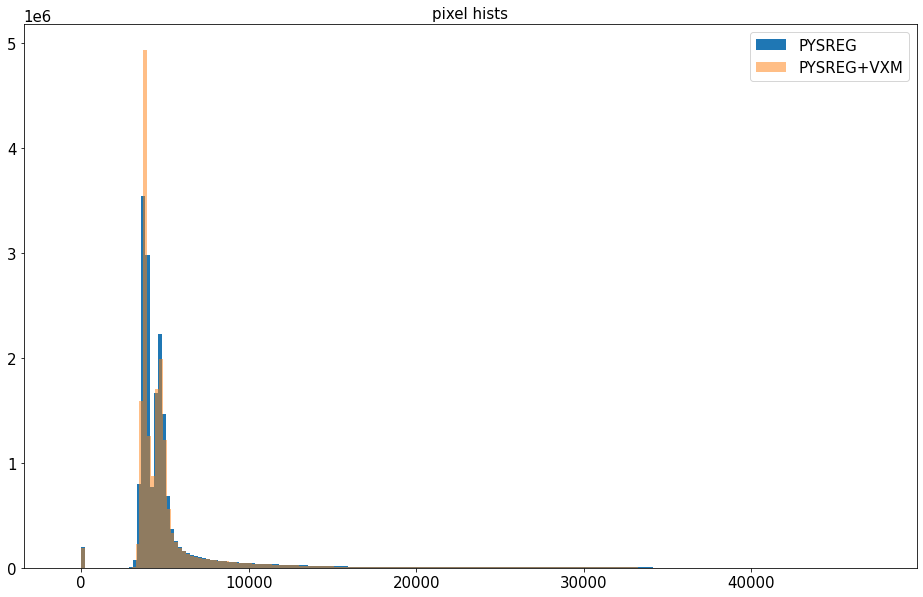

i=41


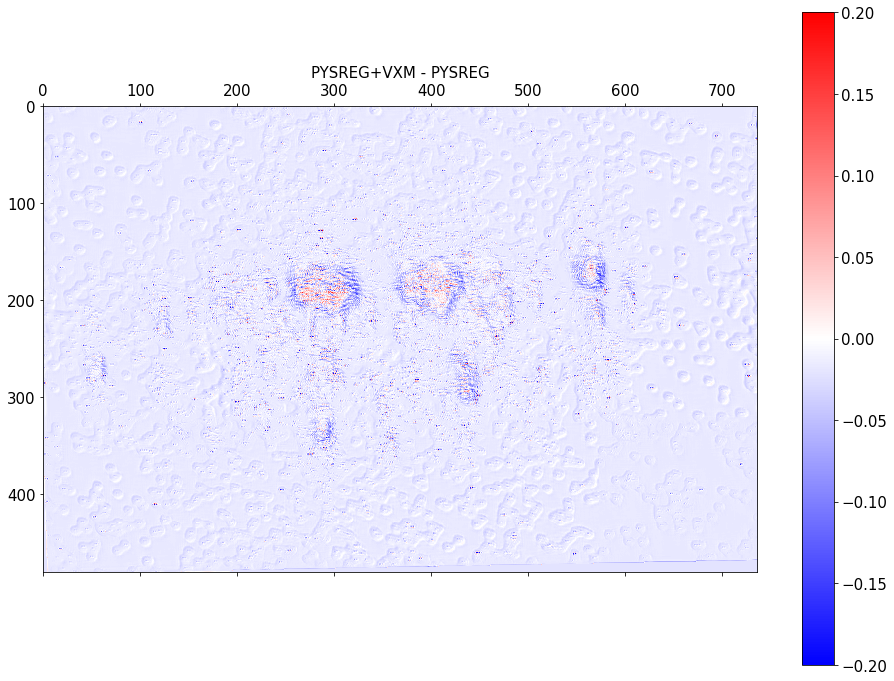

In [72]:
key=range(50)
pysreg = tiff.imread(pystackreg_examples[1], key=key)
pysreg_vxm = np.load('pysreg+vxm.npy')

print(f'{pysreg.max()=}')
print(f'{pysreg.min()=}')
print(f'{pysreg.mean()=}')
print(f'{pysreg.std()=}')
print(f'{pysreg_vxm.max()=}')
print(f'{pysreg_vxm.min()=}')
print(f'{pysreg_vxm.mean()=}')
print(f'{pysreg_vxm.std()=}')

# pixel hist
plt.figure(figsize=(16, 10))
plt.hist(pysreg.ravel(), bins=200, label=r'PYSREG')
plt.hist(pysreg_vxm.ravel(), bins=200, alpha=0.5, label=r'PYSREG+VXM')
plt.title('pixel hists')
plt.legend()
plt.show()

# normalize
low, hig = pysreg.min(), pysreg.max()
pysreg = (pysreg - low) / (hig - low)
low, hig = pysreg_vxm.min(), pysreg_vxm.max()
pysreg_vxm = (pysreg_vxm - low) / (hig - low)

i = np.random.randint(50)
print(f'{i=}')

plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ms = ax.matshow((pysreg_vxm[i] - pysreg[i]), cmap='bwr', vmin=-0.2, vmax=0.2)
plt.colorbar(ms)
plt.title('PYSREG+VXM - PYSREG')
plt.show()